# IMPORTS

In [1]:
# Imports
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False #disable ugly white lines which are present in google colab for matplotlib
import numpy as np
import datetime
today = datetime.datetime.today() #To work with datetime values. Only relative time matters in this project, so selecting a random date is not a problem. 
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
import shap
from catboost import CatBoostClassifier,CatBoostRegressor,Pool
from catboost.utils import get_roc_curve
import xgboost as xgb
import pandas as pd
import re
from tqdm import tqdm
from tabulate import tabulate
from scipy.stats import linregress,ttest_ind,ranksums
pd.options.display.float_format = '{:20,.2f}'.format
np.set_printoptions(suppress=True)
from numpy.random import RandomState

data_string = "../data/amsterdam/"

In [2]:
present = False
if present:
    params = {"ytick.color" : "w",
            "xtick.color" : "w",
            "axes.titlecolor" : "w",
            "axes.labelcolor" : "w",
            "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    plt.rcParams.update({'font.size': 18})
else:
    params = {"ytick.color" : "black",
            "xtick.color" : "black",
            "axes.titlecolor" : "black",
            "axes.labelcolor" : "black",
            "axes.edgecolor" : "black"}
    plt.rcParams.update(params)
    


# Data Import

In [4]:
def pandas_result_AF_maker(patient_group_string,X,y,model,append_df):
    (fpr, tpr, thresholds) = get_roc_curve(model, Pool(data=X,label=y), plot=False)
    res_dict = classification_report(y,model.predict(X),target_names=["No-AF","AF"],output_dict=True)

    append_df = pd.concat([append_df,pd.DataFrame(data=[[model_string,validation_type_string,patient_group_string,
                    res_dict["No-AF"]["support"],res_dict["AF"]["support"],
                    res_dict["No-AF"]["recall"],res_dict["AF"]["recall"],
                    res_dict["No-AF"]["precision"],res_dict["AF"]["precision"],
                    res_dict["No-AF"]["f1-score"],res_dict["AF"]["f1-score"],
                    matthews_corrcoef(y,model.predict(X)),auc(fpr,tpr)
                   ]],columns=amsterdam_result_dataframe_columns)])
    
    return append_df

amsterdam_result_dataframe_columns=["model","validation_type","patient_group","NO AF patients","AF patients","NO AF recall","AF recall","NO AF precision","AF precision","NO AF f1","AF f1","mcc","auc"]
# amsterdam_result_dataframe = pd.DataFrame(columns=amsterdam_result_dataframe_columns)

In [41]:
#False
#True

one_half_hour_model = False
six_hour_model = True

model_string = ("1.5"*int(one_half_hour_model)+"12"*int(1-one_half_hour_model))*int(1-six_hour_model)+"6"*int(six_hour_model)
model_string

'6'

In [42]:
validation_type_string = "base model"

if one_half_hour_model:
        AF_dataset = pd.read_csv(data_string+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
        AF_dataset = pd.read_csv(data_string+"AF_dataset_6_hours.csv") 
else:
        AF_dataset = pd.read_csv(data_string+"AF_dataset_12_hours.csv") 

In [43]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1
AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

AF_dataset['is_given_Enoximon (Perfan)']=0
AF_dataset.loc[AF_dataset['mean_Enoximon (Perfan)']>0,'is_given_Enoximon (Perfan)']=1

AF_dataset.loc[AF_dataset['mean_PEEP (Set)'].isna(),'mean_PEEP (Set)']=0

AF_dataset['is_given_Hydrocortison (Solu Cortef)']=0
AF_dataset.loc[AF_dataset['mean_Hydrocortison (Solu Cortef)']>0,'is_given_Hydrocortison (Solu Cortef)']=1

AF_dataset['is_given_Midazolam (Dormicum)']=0
AF_dataset.loc[AF_dataset['mean_Midazolam (Dormicum)']>0,'is_given_Midazolam (Dormicum)']=1

AF_dataset['is_given_Morfine']=0
AF_dataset.loc[AF_dataset['mean_Morfine']>0,'is_given_Morfine']=1

AF_dataset['is_given_Fentanyl']=0
AF_dataset.loc[AF_dataset['mean_Fentanyl']>0,'is_given_Fentanyl']=1

In [44]:

#AF_temp_db_or = AF_dataset_or[(AF_dataset_or.AF==0)&(AF_dataset_or.AF_orig==0)].sample(len(AF_dataset_or[AF_dataset_or.AF==1]),random_state=42).reset_index(drop=True)
#AF_NOW_or = AF_temp_db_or.append(AF_dataset_or[AF_dataset_or.AF==1]).reset_index(drop=True)

#AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)&(AF_dataset.patientid!=AF_dataset.date_corresponds_to_AF_admid)]
AF_temp_db = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.AF_orig==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

AF_NOW = AF_temp_db.append(AF_dataset[AF_dataset.AF==1]).reset_index(drop=True)

In [45]:
from sklearn.model_selection import train_test_split

#train_patientid,test_patientid = train_test_split(AF_NOW_or.patientid.values, test_size=0.2, random_state=42)#,stratify=AF_NOW["AF"])
#test_AF_dataset_or = AF_NOW_or[AF_NOW_or.patientid.isin(test_patientid)&(AF_NOW_or.AF==1)]
train_patientid,test_patientid = train_test_split(AF_NOW.patientid.unique(), test_size=0.2, random_state=42)#,stratify=AF_NOW["AF"])
test_AF_dataset_or = AF_NOW[AF_NOW.patientid.isin(test_patientid)&(AF_NOW.AF==1)]

#train_AF_dataset = AF_NOW[~AF_NOW.date_corresponds_to_AF_admid.isin(test_AF_dataset_or.patientid)]
#test_AF_dataset = AF_NOW[AF_NOW.date_corresponds_to_AF_admid.isin(test_AF_dataset_or.patientid)]
train_AF_dataset = AF_NOW[AF_NOW.patientid.isin(train_patientid)]
test_AF_dataset = AF_NOW[AF_NOW.patientid.isin(test_patientid)]

In [46]:
drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",#'date_corresponds_to_AF_admid',
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

In [47]:
X_train_or = train_AF_dataset[train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset[test_AF_dataset.columns.drop(drop_columns)]
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

In [48]:
X_train_or = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))][train_AF_dataset.columns.drop(drop_columns)]
X_test_or = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))][test_AF_dataset.columns.drop(drop_columns)]
y_train = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))].AF
y_test = test_AF_dataset[(test_AF_dataset.AF==1)|((test_AF_dataset.AF_orig==0)&(test_AF_dataset.AF==0))].AF

### Import Risk over Time data

In [30]:
include_ROT = False

if include_ROT:
    Include_false_pos = False
    only_data_of_first_hours = False

    #AF patients but the timestamp is not of the AF diagnosis
    min_time_difference_to_AF = 48 #The amount of hours before AF

    if only_data_of_first_hours:
        if one_half_hour_model:
            AF_dataset_false = pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_first12hours_adm_"+str(min_time_difference_to_AF)+"_hours_before.csv")
        else:
            AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_first12hours_adm_"+str(min_time_difference_to_AF)+"_hours_before.csv")
    else:
        if one_half_hour_model:
            AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_first"+str(min_time_difference_to_AF)+"hours_aft_adm.csv")
        else:
            AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_first"+str(min_time_difference_to_AF)+"hours_aft_adm.csv")

    AF_dataset_false["is_given_Magnesiumsulfaat (MgSO4)"]=0
    if 'mean_Magnesiumsulfaat (MgSO4)' in AF_dataset_false.columns:
        AF_dataset_false.loc[AF_dataset_false['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1
    #AF_dataset["min_Magnesiumsulfaat (MgSO4)"] = AF_dataset["min_Magnesiumsulfaat (MgSO4)"].fillna(0)
    AF_dataset_false["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
    if 'mean_Calcium Glubionaat (Calcium Sandoz)' in AF_dataset_false.columns:
        AF_dataset_false.loc[AF_dataset_false['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

    AF_dataset_false["is_given_LoopDiuretics"]=0
    #AF_dataset_false.loc[(AF_dataset_false['mean_Bumetanide (Burinex)']>0) | (AF_dataset_false['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1
    AF_dataset_false.loc[AF_dataset_false['mean_Furosemide (Lasix)']>0,"is_given_LoopDiuretics"]=1

    train_AF_false_dataset = AF_dataset_false[AF_dataset_false.patientid.isin(train_patientid)]
    X_train_false = train_AF_false_dataset[train_AF_false_dataset.columns.drop(drop_columns)]
    Y_train_false = train_AF_false_dataset.AF

    test_AF_false_dataset = AF_dataset_false[AF_dataset_false.patientid.isin(test_patientid)]
    X_test_false = test_AF_false_dataset[test_AF_false_dataset.columns.drop(drop_columns)]
    Y_test_false = test_AF_false_dataset.AF
        
    if Include_false_pos:
        X_train_or = X_train_or.append(X_train_false)
        y_train = np.append(y_train,Y_train_false)

### Cross-Validation

In [31]:
cross_val_amsterdam_result_dataframe_columns = ["model","uzgent_removed","AUC","AUC std","MCC","MCC std","ACCURACY","ACCURACY std","F1","F1 std","PRECISION","PRECISION std","RECALL","RECALL std"]

def cross_vall_pandas_result_AF_maker(result_dict, normal, append_df):

    append_df = pd.concat([append_df,pd.DataFrame(data=[[model_string,normal,
                    Metrics_best["AUC"][0],Metrics_best["AUC"][1],
                    Metrics_best["MCC"][0],Metrics_best["MCC"][1],
                    Metrics_best["ACCURACY"][0],Metrics_best["ACCURACY"][1],
                    Metrics_best["F1"][0],Metrics_best["F1"][1],
                    Metrics_best["PRECISION"][0],Metrics_best["PRECISION"][1],
                    Metrics_best["RECALL"][0],Metrics_best["RECALL"][1],
                   ]],columns=cross_val_amsterdam_result_dataframe_columns)])
    
    return append_df

# cross_val_amsterdam_result_dataframe = pd.DataFrame(columns=cross_val_amsterdam_result_dataframe_columns)

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


## This cross_validation is different from the standard cross validation
# Inp_db:pandas_DataFrame = input database (contains labels and features), should contain heroi2c numbers as IDs, previous concentrations
# Features:List = features to use
# Folds:int = amount of folds
# RS:int = Random state
# Output:dict = dictionary with the results of each fold
def escim_cross_validation(Model,Inp_db,folds,RS,features,verbose):
    patients_CV = Inp_db.patientid.unique()
    
    kf = KFold(n_splits=folds,shuffle=True,random_state=RS)
    
    scores_cv_train = {"AUC":np.array([]),
                 "MCC":np.array([]),      
                 "ACCURACY":np.array([]),
                 "RECALL":np.array([]),
                 "F1":np.array([]),
                 "PRECISION":np.array([])}
    
    scores_cv_test = {"AUC":np.array([]),
                    "MCC":np.array([]),
                     "ACCURACY":np.array([]),
                     "RECALL":np.array([]),
                     "F1":np.array([]),
                     "PRECISION":np.array([])}
    fold_idx = 0
    for patient_CV_train_idx, patient_CV_test_idx in kf.split(patients_CV):
        if verbose:
            print("\r Training folds: "+str(fold_idx+1)+"/"+str(folds),end="")
        fold_idx = fold_idx+1
        ## Split per patient (to avoid data leakage)
        X_CV_train = Inp_db[Inp_db.patientid.isin(patients_CV[patient_CV_train_idx])]
        X_CV_test = Inp_db[Inp_db.patientid.isin(patients_CV[patient_CV_test_idx])]
            
        ## Calculate the required labels
        target = "AF"
        
        Y_CV_train = X_CV_train[target].values
        Y_CV_test = X_CV_test[target].values
        
        ## Extract the required features
        X_CV_train_feat = X_CV_train[features]
        X_CV_test_feat = X_CV_test[features]
        
        Model.fit(X_CV_train_feat,Y_CV_train)
        Y_CV_predict_test = Model.predict(X_CV_test_feat)
        Y_CV_predict_train = Model.predict(X_CV_train_feat)
        
        ## Calculate the cross validation scores

        #(fpr_train, tpr_train, thresholds_train) = get_roc_curve(Model, Pool(data=X_CV_train_feat,label=Y_CV_train), plot=False)
        #(fpr, tpr, thresholds) = get_roc_curve(Model, Pool(data=X_CV_test_feat,label=Y_CV_test), plot=False)

        y_cv_train_pred = Model.predict_proba(X_CV_train_feat)[:,1]
        y_cv_test_pred = Model.predict_proba(X_CV_test_feat)[:,1]
        
        train_results = classification_report(Y_CV_train,Model.predict(X_CV_train_feat),output_dict=True)
        test_results = classification_report(Y_CV_test,Model.predict(X_CV_test_feat),output_dict=True)
        
        scores_cv_train["AUC"]=np.append(scores_cv_train["AUC"],roc_auc_score(Y_CV_train,y_cv_train_pred))
        scores_cv_test["AUC"]=np.append(scores_cv_test["AUC"],roc_auc_score(Y_CV_test,y_cv_test_pred))

        scores_cv_train["MCC"]=np.append(scores_cv_train["MCC"],matthews_corrcoef(Y_CV_train,Model.predict(X_CV_train_feat)))
        scores_cv_test["MCC"]=np.append(scores_cv_test["MCC"],matthews_corrcoef(Y_CV_test,Model.predict(X_CV_test_feat)))
        
        scores_cv_train["ACCURACY"]=np.append(scores_cv_train["ACCURACY"],train_results["accuracy"])
        scores_cv_test["ACCURACY"]=np.append(scores_cv_test["ACCURACY"],test_results["accuracy"])

        scores_cv_train["RECALL"]=np.append(scores_cv_train["RECALL"],train_results['weighted avg']['recall'])
        scores_cv_test["RECALL"]=np.append(scores_cv_test["RECALL"],test_results['weighted avg']['recall'])

        scores_cv_train["F1"]=np.append(scores_cv_train["F1"],train_results['weighted avg']['f1-score'])
        scores_cv_test["F1"]=np.append(scores_cv_test["F1"],test_results['weighted avg']['f1-score'])

        scores_cv_train["PRECISION"]=np.append(scores_cv_train["PRECISION"],train_results['weighted avg']['precision'])
        scores_cv_test["PRECISION"]=np.append(scores_cv_test["PRECISION"],test_results['weighted avg']['precision'])
        
    return scores_cv_train,scores_cv_test

def repeated_k_fold_cv_esicm(Model_,Inp_db_,folds_,RS_,features_,repeats_,verbose_):
    repeated_cv_test = {"AUC":[np.array([]),np.array([])],
                 "MCC":[np.array([]),np.array([])],
                 "ACCURACY":[np.array([]),np.array([])],
                 "RECALL":[np.array([]),np.array([])],
                 "F1":[np.array([]),np.array([])],
                 "PRECISION":[np.array([]),np.array([])]}
    
    repeated_cv_train = {"AUC":[np.array([]),np.array([])],
                 "MCC":[np.array([]),np.array([])],
                 "ACCURACY":[np.array([]),np.array([])],
                 "RECALL":[np.array([]),np.array([])],
                 "F1":[np.array([]),np.array([])],
                 "PRECISION":[np.array([]),np.array([])]}
    
    for i in range(repeats_):
        if verbose_:
            print("Repeat: "+str(i+1)+"/"+str(repeats_))

        train_sc,test_sc = escim_cross_validation(Model=Model_,Inp_db=Inp_db_,folds=folds_,RS=i+RS_,features=features_,verbose=verbose_)

        if verbose_:
            print("")

        for key in test_sc:
            repeated_cv_test[key][0]=np.append(repeated_cv_test[key][0],test_sc[key])
            repeated_cv_train[key][0]=np.append(repeated_cv_train[key][0],train_sc[key])
            
    for key in repeated_cv_test:
        repeated_cv_test[key]=[np.mean(repeated_cv_test[key][0]),1.96*np.std(repeated_cv_test[key][0])]
        repeated_cv_train[key]=[np.mean(repeated_cv_train[key][0]),1.96*np.std(repeated_cv_train[key][0])]
    
    return repeated_cv_train,repeated_cv_test

In [ ]:
include_ghent_excl_features = True

if one_half_hour_model:
    if not non_biased_model:
        feature_columns = ['Age',
            'slope_Hartfrequentie',
            "min_Thrombo's (bloed)",
            'is_given_Calcium Glubionaat (Calcium Sandoz)',
            'is_given_Noradrenaline (Norepinefrine)',
            'mean_O2 concentratie (Set)',
            'mean_Lactaat (bloed)',
            'mean_UrineCAD',
            'max_PO2 (bloed)',
            'mean_PEEP (Set)',
            'mean_Ureum (bloed)',
            'min_CVD',
            'is_given_LoopDiuretics',
            'fluid_balance',
            'mean_ABP gemiddeld',
            'mean_O2-Saturatie (bloed)',
            'max_pCO2 (bloed)',
            'Height',
            'mean_ABP systolisch',
        ]

        ghent_excluded_columns = [
            'mean_Hb(v.Bgs) (bloed)',
            'slope_Kalium (bloed)',
            'min_O2 l/min',
            'fluidout',
            'slope_CK (bloed)',
            'max_CRP (bloed)',
            'mean_Morfine',
            'slope_Glucose (bloed)',
            'mean_APTT  (bloed)',
            'min_Alb.Chem (bloed)',
            'fluidin',
            'max_Natrium (bloed)',
            'max_Prothrombinetijd (bloed)',
            'admissioncount',
            'slope_Cardiac Output',
            'slope_Cl (onv.ISE) (bloed)',
            'is_given_Magnesiumsulfaat (MgSO4)',
            'mean_Bezinking (bloed)',
            'min_Hb (bloed)'
        ]
       
    else:
        feature_columns = ['Age',
            'mean_Lactaat (bloed)',
            'slope_Hartfrequentie',
            'mean_UrineCAD',
            'mean_O2-Saturatie (bloed)',
            'max_PO2 (bloed)',
            'mean_O2 concentratie (Set)',
            'urgency',
            "min_Thrombo's (bloed)",
            'is_given_Noradrenaline (Norepinefrine)',
            'min_Ureum (bloed)',
            'is_given_Furosemide (Lasix)',
            'min_Act.HCO3 (bloed)',
            'Weight',
            'mean_PEEP (Set)',
            'fluid_balance',
            'mean_CVD',
            'slope_ABP systolisch',
            'min_pH (bloed)',
            'slope_ABP gemiddeld',
            ]

        ghent_excluded_columns = [
            'max_Anion-Gap (bloed)',
            'fluidout',
            'slope_O2 l/min',
            'max_Kreatinine (bloed)',
            'mean_Prothrombinetijd  (bloed)',
            'slope_APTT  (bloed)',
            'admissioncount',
            'fluidin',
            'slope_Cl (onv.ISE) (bloed)',
            'mean_Bezinking (bloed)'
        ]

else:
    if not non_biased_model:
        feature_columns = ['Age',
            'slope_Hartfrequentie',
            'slope_O2 l/min',
            'max_Hartfrequentie',
            'mean_UrineCAD',
            'mean_Lactaat (bloed)',
            'max_PO2 (bloed)',
            'Weight',
            'min_UrineCAD',
            'max_Lactaat (bloed)',
            'mean_O2 concentratie (Set)',
            'slope_UrineCAD',
            'min_Lactaat (bloed)',
            'mean_Hartfrequentie',
            'urgency',
            'min_Act.HCO3 (bloed)',
            'mean_O2-Saturatie (bloed)',
            'max_UrineCAD',
            'fluid_balance',
            'min_Hartfrequentie',
            'mean_O2 l/min',
            'slope_ABP systolisch',
            "min_Thrombo's (bloed)"]

        ghent_excluded_columns = [
            'fluidout',
            'max_O2 l/min',
            'admissioncount',
            'slope_APTT  (bloed)',
            'fluidin',
            'max_Prothrombinetijd  (bloed)']

    else:
        feature_columns = ['Age',
            'slope_Hartfrequentie',
            'mean_O2 concentratie (Set)',
            'mean_UrineCAD',
            'max_PO2 (bloed)',
            'max_CVD',
            'mean_Lactaat (bloed)',
            'min_pH (bloed)',
            'mean_O2-Saturatie (bloed)',
            'urgency',
            'mean_PEEP (Set)']

        ghent_excluded_columns = [
            'fluidout',
            'slope_O2 l/min',
            'mean_CRP (bloed)',
            'mean_Alk.Fosf. (bloed)',
            ]


if six_hour_model:
    if not non_biased_model:
        feature_columns = ['Age',
            'is_given_Calcium Glubionaat (Calcium Sandoz)',
            'min_CVD',
            'is_given_Noradrenaline (Norepinefrine)',
            'slope_Hartfrequentie',
            'mean_O2 concentratie (Set)',
            'max_UrineCAD',
            'fluid_balance',
            'max_PO2 (bloed)',
            'is_given_Furosemide (Lasix)',
            'mean_Ureum (bloed)',
            'max_Act.HCO3 (bloed)',
            'is_given_Propofol (Diprivan)',
            'mean_PEEP (Set)',
            'slope_ABP systolisch',
            'mean_O2-Saturatie (bloed)',
            ]

        ghent_excluded_columns = [
            'slope_Kalium (bloed)',
            'min_O2 l/min',
            'fluidout',
            'min_Magnesiumsulfaat (MgSO4)',
            'min_Alk.Fosf. (bloed)',
            'min_Morfine',
            'mean_Hb (bloed)',
            'max_Kreatinine (bloed)',
            'fluidin',
            'slope_Cl (onv.ISE) (bloed)',
            'slope_Glucose (bloed)',
            'slope_CK (bloed)'
        ]

    else:
        feature_columns = ['Age',
            'slope_Hartfrequentie',
            'mean_Lactaat (bloed)',
            'min_UrineCAD',
            'mean_O2 concentratie (Set)',
            'max_PO2 (bloed)',
            'min_CVD',
            'is_given_Furosemide (Lasix)',
            'fluid_balance',
            'min_ABP gemiddeld',
            'mean_PEEP (Set)',
            'mean_Act.HCO3 (bloed)',
            'min_ABP systolisch',
            'urgency',
            'slope_B.E. (bloed)']


        ghent_excluded_columns = [
            'fluidout',
            'slope_O2 l/min',
            'max_Kreatinine (bloed)',
            'mean_APTT  (bloed)',
            'mean_Prothrombinetijd  (bloed)',
            'max_Bezinking (bloed)',
            'admissioncount',
            'slope_Chloor (bloed)',
            'fluidin',
        ]

if include_ghent_excl_features:
    feature_cols_cv = feature_columns + ghent_excluded_columns
else:
    feature_cols_cv = feature_columns


METRIC = "MCC"
Metrics_best = {"AUC":[0,0],"MCC":[0,0],"ACCURACY":[0,0],"F1":[0,0],"PRECISION":[0,0],"RECALL":[0,0]}
parameter_best = {"depth":0,"learning_rate":0,"iterations":0,"l2reg":None,"Random_strength":0,"bagging_temp":0,"float_Feature":0}

dep_cv_arr = [None,1,2,3,4,5]
lr_cv_arr = [None]
its_cv_arr = [200,300,400]
l2reg_arr = [None,1,2,3,4,5]
rs_arr = [2]
loss_f = "Logloss"
random_strength_arr = [None]
bagging_temperature_arr = [None]
per_float_feature_quantization_arr=[None]

if non_biased_model:
    if one_half_hour_model:
        dep_cv_arr = [None]
        its_cv_arr = [300]
        l2reg_arr = [6]

    elif not six_hour_model:
        dep_cv_arr = [4]
        its_cv_arr = [300]
        l2reg_arr = [2]

    else:
        dep_cv_arr = [5]
        its_cv_arr = [400]
        l2reg_arr = [2]
else:
    if one_half_hour_model:
        dep_cv_arr = [None]
        its_cv_arr = [400]
        l2reg_arr = [5]

    elif not six_hour_model:
        dep_cv_arr = [None]
        its_cv_arr = [200]
        l2reg_arr = [1]

    else:
        dep_cv_arr = [5]
        its_cv_arr = [400]
        l2reg_arr = [2]


i_loop = 0
for dep_tune in dep_cv_arr:#np.arange(4):
    for lr_tune in lr_cv_arr:
        for it_tune in its_cv_arr:
            for l2_tune in l2reg_arr:
                for rand_strength in random_strength_arr: 
                    for bag_temp in bagging_temperature_arr:
                        for float_feat in per_float_feature_quantization_arr:
                            i_loop = i_loop + 1 
                            print("iteration "+str(i_loop)+"/"+str(len(dep_cv_arr)*len(lr_cv_arr)*len(its_cv_arr)*len(l2reg_arr)*len(random_strength_arr)*len(bagging_temperature_arr)*len(per_float_feature_quantization_arr)))
                            dep = dep_tune#6
                            lr = lr_tune#0.04
                            its = it_tune
                            l2reg = l2_tune
                            random_s = 2#it_tune
                            rand_strength_s = rand_strength
                            bag_temp_s = bag_temp
                            float_feat_s = float_feat

                            AF_class_balance = [train_AF_dataset.AF.sum()/len(train_AF_dataset),1-train_AF_dataset.AF.sum()/len(train_AF_dataset)]

                            cv_model = CatBoostClassifier(verbose=False,
                                                            iterations=its,
                                                            learning_rate=lr,
                                                            depth=dep,
                                                            class_weights = AF_class_balance,
                                                            l2_leaf_reg=l2reg,
                                                            bagging_temperature = bag_temp_s,
                                                            per_float_feature_quantization = float_feat_s,
                                                            random_strength = rand_strength_s,
                                                            loss_function=loss_f,
                                                            random_seed=random_s)

                            metrics_results_train,metrics_results_test = repeated_k_fold_cv_esicm(Model_=cv_model,
                                                  Inp_db_=train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))],
                                                  folds_=10,
                                                  RS_=42,
                                                  features_=feature_cols_cv,#feature_columns,#train_AF_dataset.columns.drop(drop_columns),
                                                  repeats_=2,verbose_=True)

                            print("The train metrics are: AUC : "+str(np.round(metrics_results_train["AUC"][0],4))+" ("+str(np.round(metrics_results_train["AUC"][1],4))+")"+
                                  " | MCC: "+str(np.round(metrics_results_train["MCC"][0],4))+" ("+str(np.round(metrics_results_train["MCC"][1],4))+")"+
                                  " | ACCURACY: "+str(np.round(metrics_results_train["ACCURACY"][0],4))+" ("+str(np.round(metrics_results_train["ACCURACY"][1],4))+")"+
                                  " | WEIGHTED F1: "+str(np.round(metrics_results_train["F1"][0],4))+" ("+str(np.round(metrics_results_train["F1"][1],4))+")"+
                                  " | WEIGHTED PRECISION: "+str(np.round(metrics_results_train["PRECISION"][0],4))+" ("+str(np.round(metrics_results_train["PRECISION"][1],4))+")"+
                                  " | WEIGHTED RECALL: "+str(np.round(metrics_results_train["RECALL"][0],4))+" ("+str(np.round(metrics_results_train["RECALL"][1],4))+")") 
                            print("The test metrics are: AUC : "+str(np.round(metrics_results_test["AUC"][0],4))+" ("+str(np.round(metrics_results_test["AUC"][1],4))+")"+
                                  " | MCC: "+str(np.round(metrics_results_test["MCC"][0],4))+" ("+str(np.round(metrics_results_test["MCC"][1],4))+")"+
                                  " | ACCURACY: "+str(np.round(metrics_results_test["ACCURACY"][0],4))+" ("+str(np.round(metrics_results_test["ACCURACY"][1],4))+")"+
                                  " | WEIGHTED F1: "+str(np.round(metrics_results_test["F1"][0],4))+" ("+str(np.round(metrics_results_test["F1"][1],4))+")"+
                                  " | WEIGHTED PRECISION: "+str(np.round(metrics_results_test["PRECISION"][0],4))+" ("+str(np.round(metrics_results_test["PRECISION"][1],4))+")"+
                                  " | WEIGHTED RECALL: "+str(np.round(metrics_results_test["RECALL"][0],4))+" ("+str(np.round(metrics_results_test["RECALL"][1],4))+")") 
                            print(50*"=")
                            if metrics_results_test[METRIC][0]>Metrics_best[METRIC][0]:
                                Metrics_best=metrics_results_test
                                parameter_best["depth"]=dep
                                parameter_best["learning_rate"]=lr
                                parameter_best["iterations"]=its
                                parameter_best["l2reg"]=l2reg
                                parameter_best["Random_strength"]=rand_strength_s
                                parameter_best["bagging_temp"]=bag_temp
                                parameter_best["float_Feature"]=float_feat

print(50*"=")                    
print("The test metrics are: AUC : "+str(np.round(Metrics_best["AUC"][0],4))+" ("+str(np.round(Metrics_best["AUC"][1],4))+")"+
                      " | MCC: "+str(np.round(Metrics_best["MCC"][0],4))+" ("+str(np.round(Metrics_best["MCC"][1],4))+")"+
                      " | ACCURACY: "+str(np.round(Metrics_best["ACCURACY"][0],4))+" ("+str(np.round(Metrics_best["ACCURACY"][1],4))+")"+
                      " | WEIGHTED F1: "+str(np.round(Metrics_best["F1"][0],4))+" ("+str(np.round(Metrics_best["F1"][1],4))+")"+
                      " | WEIGHTED PRECISION: "+str(np.round(Metrics_best["PRECISION"][0],4))+" ("+str(np.round(Metrics_best["PRECISION"][1],4))+")"+
                      " | WEIGHTED RECALL: "+str(np.round(Metrics_best["RECALL"][0],4))+" ("+str(np.round(Metrics_best["RECALL"][1],4))+")") 
print(parameter_best)

cross_val_amsterdam_result_dataframe = cross_vall_pandas_result_AF_maker(Metrics_best, "without" if not include_ghent_excl_features else "included", cross_val_amsterdam_result_dataframe)

In [98]:
cross_val_amsterdam_result_dataframe.sort_values(["model","uzgent_removed"]).reset_index(drop=True)

,model,uzgent_removed,AUC,AUC std,MCC,MCC std,ACCURACY,ACCURACY std,F1,F1 std,PRECISION,PRECISION std,RECALL,RECALL std
0,1.5u,included,0.87,0.03,0.54,0.09,0.78,0.04,0.78,0.04,0.79,0.04,0.78,0.04
1,1.5u,without,0.86,0.04,0.53,0.09,0.77,0.04,0.77,0.04,0.78,0.04,0.77,0.04
2,1.5u old,included,0.90,0.03,0.63,0.07,0.82,0.03,0.82,0.03,0.82,0.03,0.82,0.03
3,1.5u old,without,0.88,0.03,0.61,0.07,0.80,0.04,0.80,0.04,0.80,0.03,0.80,0.04
4,12u,included,0.82,0.03,0.48,0.07,0.74,0.03,0.74,0.03,0.75,0.02,0.74,0.03
5,12u,without,0.81,0.04,0.47,0.09,0.74,0.04,0.74,0.04,0.75,0.03,0.74,0.04
6,12u old,included,0.83,0.04,0.51,0.10,0.75,0.05,0.75,0.05,0.75,0.05,0.75,0.05
7,12u old,without,0.82,0.04,0.48,0.09,0.74,0.05,0.74,0.05,0.74,0.05,0.74,0.05
8,6u,included,0.83,0.03,0.46,0.06,0.74,0.03,0.74,0.03,0.75,0.04,0.74,0.03
9,6u,without,0.81,0.05,0.45,0.08,0.73,0.04,0.74,0.04,0.74,0.04,0.73,0.04


In [99]:
# cross_val_amsterdam_result_dataframe.to_csv("../results/cross_val_results_with_features_with_without_uzgent_new.csv",index=False)

In [ ]:
## FEATURE SELECTION
features_to_select = ['Age', 'mean_O2 concentratie (Set)', 'mean_PEEP (Set)',
                        'max_CVD',  'max_UrineCAD',
                        'max_Fosfaat (bloed)', 
                        'is_given_Enoximon (Perfan)', 'mean_Lactaat (bloed)',
                        'max_Kreatinine (bloed)', 
                        'max_Hartfrequentie',
                        'is_given_Noradrenaline (Norepinefrine)',
                        'fluidout',  'max_Hb (bloed)', "mean_Thrombo's (bloed)",
                        'cardiac_surg_bool',
                        'mean_pH (bloed)', 'mean_O2-Saturatie (bloed)',
                        ]



CV_features_arr_final = ['Age']#,'mean_PEEP (Set)','max_Hartfrequentie']

Metric_changed = True

METRIC = "MCC"
Metrics_best = {"AUC":np.array([0,0]),
                "MCC":np.array([0,0]),
                 "ACCURACY":np.array([0,0]),
                 "RECALL":np.array([0,0]),
                 "F1":np.array([0,0]),
                 "PRECISION":np.array([0,0])}


#Forward feature selection method
while Metric_changed:
    print(60*"=")
    print("Iteration to select the "+str(len(CV_features_arr_final)+1)+"th feature.")
    
    #To keep the feature selection going
    Metric_changed = False
    
    feature_idx = 1
    for cv_feature in features_to_select:
        print("\r Feature "+str(feature_idx)+"/"+str(len(features_to_select)),end="")
        feature_idx = feature_idx + 1
        if cv_feature not in CV_features_arr_final:

            CV_features_current = CV_features_arr_final+[cv_feature]

            AF_class_balance = [train_AF_dataset.AF.sum()/len(train_AF_dataset),1-train_AF_dataset.AF.sum()/len(train_AF_dataset)]

            CB_AF = CatBoostClassifier(verbose=False,iterations=350,l2_leaf_reg=4,depth=4)           

            train_sc,test_sc = repeated_k_fold_cv_esicm(Model_=CB_AF,
                          Inp_db_=train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))],
                          folds_=10,
                          RS_=42,
                          features_=CV_features_current,#feature_columns,#train_AF_dataset.columns.drop(drop_columns),
                          repeats_=2,
                          verbose_=False)

            if test_sc[METRIC][0]>Metrics_best[METRIC][0]:
                Metrics_best=test_sc
                CV_features_current_best = CV_features_current
                Metric_changed = True
                
    print("\n")
    CV_features_arr_final = CV_features_current_best
    print("Current features: "+str(CV_features_arr_final))
    print("Status update: The current best metrics are AUC: "+str(np.round(Metrics_best["AUC"][0],4))+" ("+str(np.round(Metrics_best["AUC"][1],4))+")"+
        " | MCC: "+str(np.round(Metrics_best["MCC"][0],4))+" ("+str(np.round(Metrics_best["MCC"][1],4))+")"+
        " | ACCURACY: "+str(np.round(Metrics_best["ACCURACY"][0],4))+" ("+str(np.round(Metrics_best["ACCURACY"][1],4))+")"+
        " | WEIGHTED F1: "+str(np.round(Metrics_best["F1"][0],4))+" ("+str(np.round(Metrics_best["F1"][1],4))+")"+
        " | WEIGHTED PRECISION: "+str(np.round(Metrics_best["PRECISION"][0],4))+" ("+str(np.round(Metrics_best["PRECISION"][1],4))+")"+
        " | WEIGHTED RECALL: "+str(np.round(Metrics_best["RECALL"][0],4))+" ("+str(np.round(Metrics_best["RECALL"][1],4))+")")

print(60*"=")
 
print("The test metrics are: AUC : "+str(np.round(Metrics_best["AUC"][0],4))+" ("+str(np.round(Metrics_best["AUC"][1],4))+")"+
      " | MCC: "+str(np.round(Metrics_best["MCC"][0],4))+" ("+str(np.round(Metrics_best["MCC"][1],4))+")"+
        " | ACCURACY: "+str(np.round(Metrics_best["ACCURACY"][0],4))+" ("+str(np.round(Metrics_best["ACCURACY"][1],4))+")"+
        " | WEIGHTED F1: "+str(np.round(Metrics_best["F1"][0],4))+" ("+str(np.round(Metrics_best["F1"][1],4))+")"+
        " | WEIGHTED PRECISION: "+str(np.round(Metrics_best["PRECISION"][0],4))+" ("+str(np.round(Metrics_best["PRECISION"][1],4))+")"+
        " | WEIGHTED RECALL: "+str(np.round(Metrics_best["RECALL"][0],4))+" ("+str(np.round(Metrics_best["RECALL"][1],4))+")"+"\n with the features: "+str(CV_features_arr_final) ) 

### Powershap

In [ ]:
X = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))].copy(deep=True)


train_idx, val_idx = train_test_split(
    np.arange(len(X)),
    test_size=0.2,
)
X_train = X.iloc[train_idx]

print(X_train)

In [ ]:
from powershap import PowerShap

Inp_db = train_AF_dataset[(train_AF_dataset.AF==1)|((train_AF_dataset.AF_orig==0)&(train_AF_dataset.AF==0))].copy(deep=True)

feature_cols = list(AF_dataset.columns.drop(drop_columns+["date_corresponds_to_AF_admid"]).values) #[x for x in causal_cols_CATE if not re.search("kurt|max|min|slope|causal|mean_Nor|date_corresponds",x)]#kurt|max|min|slope|causal|mean_Nor|date_corresponds",x)]
feature_cols = [x for x in feature_cols if not re.search("kurt|causal|date_corresponds",x)]

selector = PowerShap(
    model = CatBoostClassifier(verbose=0, n_estimators=400, depth=None, l2_leaf_reg=5, use_best_model=True),
    verbose=True,force_convergence=False,limit_convergence_its=1
)
selector.fit(Inp_db[feature_cols].reset_index(drop=True), Inp_db["AF"].values)

## Testing

In [49]:
include_ghent_excl_features = False

if one_half_hour_model:
    feature_columns = ['Age',
        'mean_Lactaat (bloed)',
        'slope_Hartfrequentie',
        'mean_UrineCAD',
        'mean_O2-Saturatie (bloed)',
        'max_PO2 (bloed)',
        'mean_O2 concentratie (Set)',
        'urgency',
        "min_Thrombo's (bloed)",
        'is_given_Noradrenaline (Norepinefrine)',
        'min_Ureum (bloed)',
        'is_given_Furosemide (Lasix)',
        'min_Act.HCO3 (bloed)',
        'Weight',
        'mean_PEEP (Set)',
        'fluid_balance',
        'mean_CVD',
        'slope_ABP systolisch',
        'min_pH (bloed)',
        'slope_ABP gemiddeld',
        ]

    ghent_excluded_columns = [
        'max_Anion-Gap (bloed)',
        'fluidout',
        'slope_O2 l/min',
        'max_Kreatinine (bloed)',
        'mean_Prothrombinetijd  (bloed)',
        'slope_APTT  (bloed)',
        'admissioncount',
        'fluidin',
        'slope_Cl (onv.ISE) (bloed)',
        'mean_Bezinking (bloed)'
    ]

elif six_hour_model:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'is_given_Noradrenaline (Norepinefrine)',
        'mean_Lactaat (bloed)',
        'min_UrineCAD',
        'mean_O2 concentratie (Set)',
        'max_PO2 (bloed)',
        'min_CVD',
        'is_given_Furosemide (Lasix)',
        'fluid_balance',
        'min_ABP gemiddeld',
        'mean_PEEP (Set)',
        'mean_Act.HCO3 (bloed)',
        'min_ABP systolisch',
        'urgency',
        'slope_B.E. (bloed)']


    ghent_excluded_columns = [
        'fluidout',
        'slope_O2 l/min',
        'max_Kreatinine (bloed)',
        'mean_APTT  (bloed)',
        'mean_Prothrombinetijd  (bloed)',
        'max_Bezinking (bloed)',
        'admissioncount',
        'slope_Chloor (bloed)',
        'fluidin',
    ]

else:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'mean_O2 concentratie (Set)',
        'mean_UrineCAD',
        'max_PO2 (bloed)',
        'max_CVD',
        'mean_Lactaat (bloed)',
        'min_pH (bloed)',
        'mean_O2-Saturatie (bloed)',
        'urgency',
        'mean_PEEP (Set)']

    ghent_excluded_columns = [
        'fluidout',
        'slope_O2 l/min',
        'mean_CRP (bloed)',
        'mean_Alk.Fosf. (bloed)',
        ]



if include_ghent_excl_features:
    feature_columns = feature_columns + ghent_excluded_columns

        
X_train=X_train_or[feature_columns]    
X_test= X_test_or[feature_columns] 

In [50]:
AF_class_balance = [y_train.sum()/len(y_train), 1-y_train.sum()/len(y_train)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=6, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=5, l2_leaf_reg=2, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=4, l2_leaf_reg=2, class_weights=AF_class_balance)


CB_AF.fit(X_train, y_train, eval_set=(X_test, y_test))


0:	learn: 0.6869308	test: 0.6870223	best: 0.6870223 (0)	total: 17.4ms	remaining: 6.96s
100:	learn: 0.5352849	test: 0.5663834	best: 0.5663093 (99)	total: 207ms	remaining: 611ms
200:	learn: 0.4974133	test: 0.5613813	best: 0.5606881 (173)	total: 388ms	remaining: 384ms
300:	learn: 0.4673830	test: 0.5622769	best: 0.5606881 (173)	total: 575ms	remaining: 189ms
399:	learn: 0.4364955	test: 0.5676855	best: 0.5606881 (173)	total: 758ms	remaining: 0us

bestTest = 0.5606881174
bestIteration = 173

Shrink model to first 174 iterations.


In [51]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.76      0.74      0.75      1305
          AF       0.76      0.77      0.77      1361

    accuracy                           0.76      2666
   macro avg       0.76      0.76      0.76      2666
weighted avg       0.76      0.76      0.76      2666



In [52]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

amsterdam_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,amsterdam_result_dataframe)

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.71      0.74      0.72       350
          AF       0.69      0.67      0.68       311

    accuracy                           0.70       661
   macro avg       0.70      0.70      0.70       661
weighted avg       0.70      0.70      0.70       661



AUC = 0.7804
MCC = 0.4039


### P-value calculation

In [53]:
if one_half_hour_model:
    #1,5
    y_test_1_5 = y_test
    predict_1_5 = CB_AF.predict(X_test)
    check_1_5 = 1

elif not six_hour_model:
    #6
    y_test_6 = y_test
    predict_6 = CB_AF.predict(X_test)
    check_6 = 1

else:
    #12
    y_test_12 = y_test
    predict_12 = CB_AF.predict(X_test)
    check_12 = 1


In [54]:
# #bonferri correction: alpha/m, with m the amount of total tests
# from scipy.stats import ranksums

# internal_p_value_dataframe = pd.DataFrame(columns=["Comparison 1","Comparison 2","p_value"])

# internal_p_value_dataframe = internal_p_value_dataframe.append(pd.DataFrame(data=[["1_5","6",ranksums(predict_1_5,predict_6)[1]]],columns=["Comparison 1","Comparison 2","p_value"]))
# internal_p_value_dataframe = internal_p_value_dataframe.append(pd.DataFrame(data=[["1_5","12",ranksums(predict_1_5,predict_12)[1]]],columns=["Comparison 1","Comparison 2","p_value"]))
# internal_p_value_dataframe = internal_p_value_dataframe.append(pd.DataFrame(data=[["6","12",ranksums(predict_6,predict_12)[1]]],columns=["Comparison 1","Comparison 2","p_value"]))

# internal_p_value_dataframe.reset_index(drop=True).to_csv("../results/internal_p_value.csv",index=False)

#### All testing

In [55]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.patientid.isin(AF_NOW.patientid)))|(AF_dataset.patientid.isin(test_AF_dataset.patientid))]

y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]


print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

amsterdam_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,amsterdam_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.68      0.81     13320
          AF       0.05      0.67      0.09       311

    accuracy                           0.68     13631
   macro avg       0.52      0.67      0.45     13631
weighted avg       0.97      0.68      0.79     13631



AUC = 0.7491
MCC = 0.1101
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.71      0.74      0.72       350
          AF       0.69      0.67      0.68       311

    accuracy                           0.70       661
   macro avg       0.70      0.70      0.70       661
weighted avg       0.70      0.70      0.70       661



AUC = 0.7804
MCC = 0.4039


In [58]:
amsterdam_result_dataframe.sort_values(["model","patient_group"])
# amsterdam_result_dataframe.sort_values(["model","patient_group"]).to_csv("../results/internal_amsterdam_result_dataframe.csv",index=False)

,model,validation_type,patient_group,NO AF patients,AF patients,NO AF recall,AF recall,NO AF precision,AF precision,NO AF f1,AF f1,mcc,auc
0,1.5,base model,all patients,13191,344,0.71,0.74,0.99,0.06,0.82,0.11,0.15,0.80
0,1.5,base model,balanced test,378,344,0.73,0.74,0.75,0.71,0.74,0.72,0.47,0.81
0,12,base model,all patients,7733,298,0.58,0.74,0.98,0.06,0.73,0.12,0.12,0.72
0,12,base model,balanced test,298,298,0.63,0.74,0.71,0.67,0.67,0.70,0.37,0.75
0,6,base model,all patients,13320,311,0.68,0.67,0.99,0.05,0.81,0.09,0.11,0.75
0,6,base model,balanced test,350,311,0.74,0.67,0.71,0.69,0.72,0.68,0.40,0.78


In [127]:
if one_half_hour_model:
    X_train_renamed = X_train.rename(columns={'mean_O2 l/min':'Mean O2 l/min', 'max_Hartfrequentie':'Max heart frequency', 'mean_PEEP (Set)':'Mean PEEP setting',
       'is_given_Noradrenaline (Norepinefrine)':'Is given Noradrenaline', 'max_Ureum (bloed)':'Max blood ureum',
       'is_given_Furosemide (Lasix)':'Is given Furosemide (Lasix)', 'is_given_Dopamine (Inotropin)':'Is given Dopamine (Inotropin)',
       'cardiac_surg_bool':'Cardiac surgery', 'max_Thrombo\'s (bloed)':'Max Platelets'}) 
    X_test_renamed = X_test.rename(columns={'mean_O2 l/min':'Mean O2 l/min', 'max_Hartfrequentie':'Max heart frequency', 'mean_PEEP (Set)':'Mean PEEP setting',
       'is_given_Noradrenaline (Norepinefrine)':'Is given Noradrenaline', 'max_Ureum (bloed)':'Max blood ureum',
       'is_given_Furosemide (Lasix)':'Is given Furosemide (Lasix)', 'is_given_Dopamine (Inotropin)':'Is given Dopamine (Inotropin)',
       'cardiac_surg_bool':'Cardiac surgery', 'max_Thrombo\'s (bloed)':'Max Platelets'}) 
else:
    X_train_renamed = X_train.rename(columns={'mean_PEEP (Set)':'Mean PEEP setting', 'mean_Fosfaat (bloed)':'Mean blood phosphate',
           'mean_UrineCAD':"Mean Urine volume", 'max_Hartfrequentie':'Max heart frequency', 'mean_O2 l/min':'Mean O2 l/min',
           'max_Thrombo\'s (bloed)':'Max Platelets', 'kurt_CVD':'Central Venous Pressure',
           'is_given_Noradrenaline (Norepinefrine)':'Is given Noradrenaline', 'cardiac_surg_bool':'Cardiac surgery','fluidout':'Fluidout',
           'is_given_Fentanyl':'Is given Fentanyl', 'is_given_Propofol (Diprivan)':'Is given Propofol (Diprivan)'}) 
    X_test_renamed = X_test.rename(columns={'mean_PEEP (Set)':'Mean PEEP setting', 'mean_Fosfaat (bloed)':'Mean blood phosphate',
           'mean_UrineCAD':"Mean Urine volume", 'max_Hartfrequentie':'Max heart frequency', 'mean_O2 l/min':'Mean O2 l/min',
           'max_Thrombo\'s (bloed)':'Max Platelets', 'kurt_CVD':'Central Venous Pressure',
           'is_given_Noradrenaline (Norepinefrine)':'Is given Noradrenaline', 'cardiac_surg_bool':'Cardiac surgery','fluidout':'Fluidout',
           'is_given_Fentanyl':'Is given Fentanyl', 'is_given_Propofol (Diprivan)':'Is given Propofol (Diprivan)'}) 

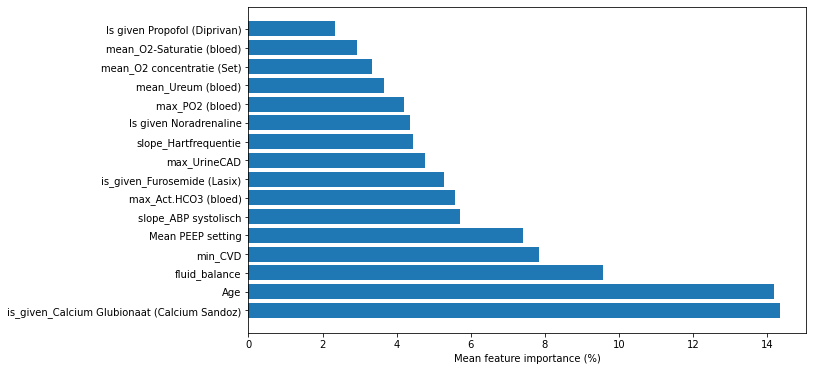

In [128]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train_renamed.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
#plt.tight_layout()
plt.show()

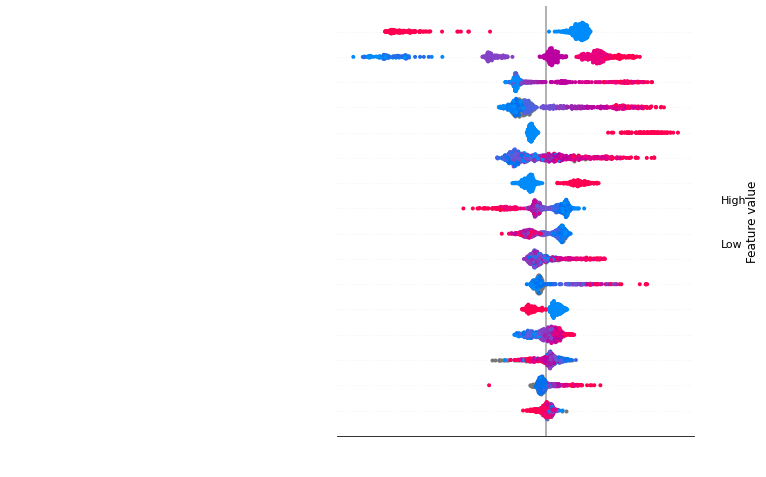

In [129]:
present=True

explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test_renamed,show=False)
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
    ax.xaxis.label.set_color('w')
    ax.yaxis.label.set_color('w')
    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')

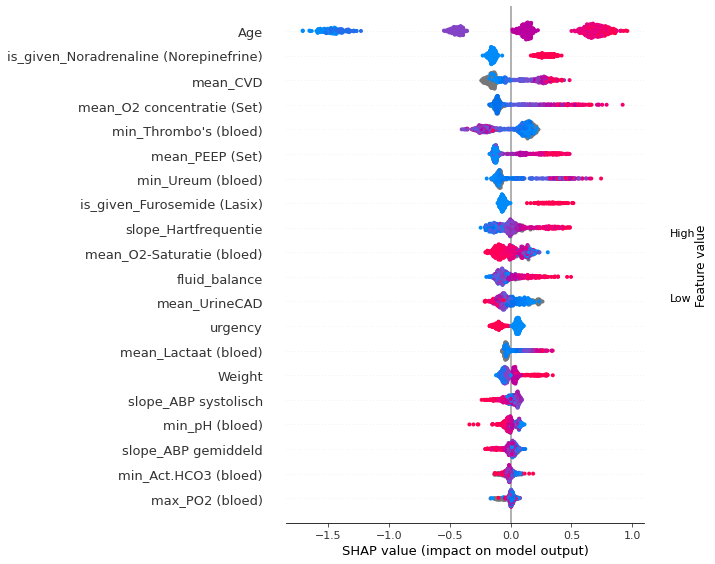

In [33]:
explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,show=False)

In [34]:
patient_idx = 3
print(X_test_false[feature_columns].iloc[patient_idx,:])
explainer = shap.TreeExplainer(CB_AF)
shap_values_test = explainer.shap_values(X_test_false[feature_columns])
fig = shap.force_plot(explainer.expected_value, shap_values_test[patient_idx,:], X_test_false[feature_columns].iloc[patient_idx,:].index, plot_cmap=["#7fcc12","#560aa5"],matplotlib=True,show=False)

NameError: name 'X_test_false' is not defined

In [ ]:
explainer = shap.TreeExplainer(CB_AF)
shap_values_test = explainer.shap_values(X_test)
fig = shap.force_plot(explainer.expected_value, shap_values_test[2,:], X_test.iloc[2,:].index, plot_cmap=["#7fcc12","#560aa5"],matplotlib=True,show=False)

In [ ]:
explainer = shap.TreeExplainer(CB_AF)
shap_values_test = explainer.shap_values(X_test)
fig = shap.force_plot(explainer.expected_value, shap_values_test[412,:], X_test.loc[1965,:].index, plot_cmap=["#7fcc12","#560aa5"],matplotlib=True,show=False)

In [ ]:
idx = 5
explainer = shap.TreeExplainer(CB_AF)
shap_values_test = explainer.shap_values(X_test_false[feature_columns])
fig = shap.force_plot(explainer.expected_value, shap_values_test[idx,:], X_test_false[feature_columns].iloc[idx,:].index, plot_cmap=["#7fcc12","#560aa5"],matplotlib=True,show=False)

## Risk over time visualization
To evaluatie this, run the Data Import section of AF data preparation. 

In [170]:
include_ghent_excl_features = False

if one_half_hour_model:
    feature_columns = ['Age',
        'mean_Lactaat (bloed)',
        'slope_Hartfrequentie',
        'mean_UrineCAD',
        'mean_O2-Saturatie (bloed)',
        'max_PO2 (bloed)',
        'mean_O2 concentratie (Set)',
        'urgency',
        "min_Thrombo's (bloed)",
        'is_given_Noradrenaline (Norepinefrine)',
        'min_Ureum (bloed)',
        'is_given_Furosemide (Lasix)',
        'min_Act.HCO3 (bloed)',
        'Weight',
        'mean_PEEP (Set)',
        'fluid_balance',
        'mean_CVD',
        'slope_ABP systolisch',
        'min_pH (bloed)',
        'slope_ABP gemiddeld',
        ]

    ghent_excluded_columns = [
        'max_Anion-Gap (bloed)',
        'fluidout',
        'slope_O2 l/min',
        'max_Kreatinine (bloed)',
        'mean_Prothrombinetijd  (bloed)',
        'slope_APTT  (bloed)',
        'admissioncount',
        'fluidin',
        'slope_Cl (onv.ISE) (bloed)',
        'mean_Bezinking (bloed)'
    ]


elif six_hour_model:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'mean_Lactaat (bloed)',
        'min_UrineCAD',
        'mean_O2 concentratie (Set)',
        'max_PO2 (bloed)',
        'min_CVD',
        'is_given_Furosemide (Lasix)',
        'fluid_balance',
        'min_ABP gemiddeld',
        'mean_PEEP (Set)',
        'mean_Act.HCO3 (bloed)',
        'min_ABP systolisch',
        'urgency',
        'slope_B.E. (bloed)']


    ghent_excluded_columns = [
        'fluidout',
        'slope_O2 l/min',
        'max_Kreatinine (bloed)',
        'mean_APTT  (bloed)',
        'mean_Prothrombinetijd  (bloed)',
        'max_Bezinking (bloed)',
        'admissioncount',
        'slope_Chloor (bloed)',
        'fluidin',
    ]
    
else:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'mean_O2 concentratie (Set)',
        'mean_UrineCAD',
        'max_PO2 (bloed)',
        'max_CVD',
        'mean_Lactaat (bloed)',
        'min_pH (bloed)',
        'mean_O2-Saturatie (bloed)',
        'urgency',
        'mean_PEEP (Set)']

    ghent_excluded_columns = [
        'fluidout',
        'slope_O2 l/min',
        'mean_CRP (bloed)',
        'mean_Alk.Fosf. (bloed)',
        ]


X_train=X_train_or[feature_columns]    
X_test=X_test_or[feature_columns]   

AF_class_balance = [y_train.sum()/len(y_train), 1-y_train.sum()/len(y_train)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=6, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=5, l2_leaf_reg=2, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=4, l2_leaf_reg=2, class_weights=AF_class_balance)

CB_AF.fit(X_train,y_train)

### Patient level

96/100

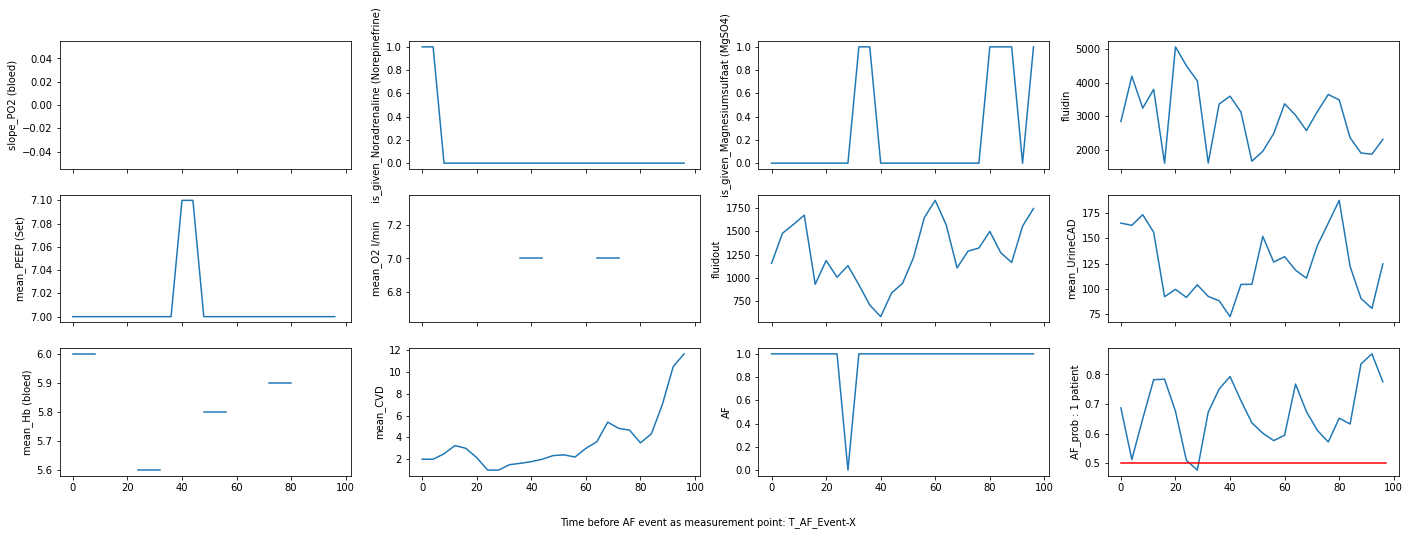

In [46]:
only_data_of_first_hours = False #Use the sliding window starting from admission, otherwise start from moment of measurement (so forward sliding vs reverse sliding)
percentage_time_diff = False #the time increments are relative, where each step the sliding window is adjusted according to a percentage instead of a fixed hour
no_af_eval = False #change the roles, where we evaluate the performance of the model on NO AF patients across time

patient_admissionid = 720

start_for_arange = 0 #if only_data_of_first_hours else 4
end_for_arange = 97#201

feat_change = { 'slope_PO2 (bloed)':np.array([]), 'is_given_Noradrenaline (Norepinefrine)':np.array([]), 'is_given_Magnesiumsulfaat (MgSO4)':np.array([]),
                       'fluidin':np.array([]), 'mean_PEEP (Set)':np.array([]),
                       'mean_O2 l/min':np.array([]), 'fluidout':np.array([]), 'mean_UrineCAD':np.array([]), 'mean_Hb (bloed)':np.array([]),  'mean_CVD':np.array([]),"AF":np.array([]),"AF_prob":np.array([])}

drop_plot = np.array([])

for min_time_difference_to_AF in np.arange(start_for_arange,end_for_arange,4):
    print("\r"+str(min_time_difference_to_AF)+"/100",end="")
    
    if only_data_of_first_hours:
        if one_half_hour_model:
            AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_first"+str(min_time_difference_to_AF)+"hours_aft_adm.csv")
        else:
            AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_first"+str(min_time_difference_to_AF)+"hours_aft_adm.csv")
    else:
        if percentage_time_diff:
            if one_half_hour_model:
                if no_af_eval:
                    AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_percentage_"+str(min_time_difference_to_AF)+"_percent_before_incl_noaf_patients.csv")
                else:
                    AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_percentage_"+str(min_time_difference_to_AF)+"_percent_before.csv")
            else:
                if no_af_eval:
                    AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_percentage_"+str(min_time_difference_to_AF)+"_percent_before_incl_noaf_patients.csv")
                else:
                    AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_percentage_"+str(min_time_difference_to_AF)+"_percent_before.csv")
        else:
            if one_half_hour_model:
                AF_dataset_false = pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_"+str(min_time_difference_to_AF)+"_hours_before.csv")
            else:
                AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_"+str(min_time_difference_to_AF)+"_hours_before.csv")
    
    AF_dataset_false["is_given_Magnesiumsulfaat (MgSO4)"]=0
    AF_dataset_false.loc[AF_dataset_false['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1
    #AF_dataset_false["min_Magnesiumsulfaat (MgSO4)"] = AF_dataset_false["min_Magnesiumsulfaat (MgSO4)"].fillna(0)
    AF_dataset_false["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
    AF_dataset_false.loc[AF_dataset_false['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

    AF_dataset_false["is_given_LoopDiuretics"]=0
    if 'mean_Bumetanide (Burinex)' in AF_dataset_false.columns:
        AF_dataset_false.loc[(AF_dataset_false['mean_Bumetanide (Burinex)']>0) | (AF_dataset_false['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

    AF_dataset_false['is_given_Propofol (Diprivan)']=0
    AF_dataset_false.loc[AF_dataset_false['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

    AF_dataset_false['is_given_Dopamine (Inotropin)']=0
    AF_dataset_false.loc[AF_dataset_false['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

    AF_dataset_false.loc[AF_dataset_false['mean_PEEP (Set)'].isna(),'mean_PEEP (Set)']=0

    if no_af_eval:
        test_AF_false_dataset = AF_dataset_false[AF_dataset_false.patientid.isin(test_AF_dataset[(test_AF_dataset.AF==0)].patientid)]
    else:
        test_AF_false_dataset = AF_dataset_false[AF_dataset_false.patientid.isin(test_patientid)]

    # print(test_AF_false_dataset.admissionid.values)
    
    if patient_admissionid in test_AF_false_dataset.admissionid.values:
        for key in feat_change.keys():
            if key == "AF":
                feat_change[key] = np.append(feat_change[key],CB_AF.predict(test_AF_false_dataset[test_AF_false_dataset.admissionid==patient_admissionid][feature_columns]))
            elif key == "AF_prob":
                if no_af_eval:
                    feat_change[key] = np.append(feat_change[key],CB_AF.predict_proba(test_AF_false_dataset[test_AF_false_dataset.admissionid==patient_admissionid][feature_columns])[:,0])
                else:
                    feat_change[key] = np.append(feat_change[key],CB_AF.predict_proba(test_AF_false_dataset[test_AF_false_dataset.admissionid==patient_admissionid][feature_columns])[:,1])
            else:
                feat_change[key] = np.append(feat_change[key],test_AF_false_dataset[test_AF_false_dataset.admissionid==patient_admissionid][key])
    else:
        print("")
        print("ERROR admissionid not found in the dataset")
        drop_plot = np.append(drop_plot,np.int(min_time_difference_to_AF/4)-1)
            
fig,axs = plt.subplots(3,4,figsize=(24,8),sharex=True)

i = 0
for key in feat_change.keys():
    axs[int(i/4),i%4].plot(np.delete(np.arange(start_for_arange,end_for_arange,4),drop_plot.astype(int)),feat_change[key])
    
    if key == "AF_prob":
        axs[int(i/4),i%4].plot([start_for_arange,end_for_arange],[0.5,0.5],color="red")
        axs[int(i/4),i%4].set_ylabel(key+ " : "+str(AF_dataset[AF_dataset.admissionid==patient_admissionid]["AF"].values[0])+" patient")
    else:
        axs[int(i/4),i%4].set_ylabel(key)

    i = i+1
    
if only_data_of_first_hours:
    fig.text(0.5, 0.04, "Data window of X+12 to X+24 hours after admission", ha='center')
else:
    if percentage_time_diff:
        fig.text(0.35, 0.04, "Percentage Time before AF event as measurement point: T_AF_Event*(1-X/100)")
    else:
        fig.text(0.5, 0.04, "Time before AF event as measurement point: T_AF_Event-X", ha='center')


### Global level

In [87]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [ ]:
only_data_of_first_hours = False #Use the sliding window starting from admission, otherwise start from moment of measurement (so forward sliding vs reverse sliding)
percentage_time_diff = False #the time increments are relative, where each step the sliding window is adjusted according to a percentage instead of a fixed hour
no_af_eval = False #change the roles, where we evaluate the performance of the model on NO AF patients across time

distr_change = False
if distr_change:
    save_csv_str_add = "_no_af_distribution_matched"
else:
    save_csv_str_add = ""

results = {"recall_FP":np.array([])
            ,"mean_prob":np.array([])
            ,"std_prob":np.array([])
            ,"AUC":np.array([])
            ,"MCC":np.array([])
            ,"dataset_size":np.array([])}

start_for_arange = 0 #if only_data_of_first_hours else 4
end_for_arange = 97#201

for min_time_difference_to_AF in np.arange(start_for_arange,end_for_arange,4):
    #print("\r"+str(min_time_difference_to_AF)+"/"+str(end_for_arange-1),end="")
    
    if only_data_of_first_hours:
        if one_half_hour_model:
            AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_first"+str(min_time_difference_to_AF)+"hours_aft_adm"+save_csv_str_add+".csv")
        else:
            AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_first"+str(min_time_difference_to_AF)+"hours_aft_adm"+save_csv_str_add+".csv")
    else:
        if percentage_time_diff:
            if one_half_hour_model: 
                if no_af_eval:
                    AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_percentage_"+str(min_time_difference_to_AF)+"_percent_before_incl_noaf_patients"+save_csv_str_add+".csv")
                else:
                    AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_percentage_"+str(min_time_difference_to_AF)+"_percent_before"+save_csv_str_add+".csv")
            else:
                if no_af_eval:
                    AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_percentage_"+str(min_time_difference_to_AF)+"_percent_before_incl_noaf_patients"+save_csv_str_add+".csv")
                else:
                    AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_percentage_"+str(min_time_difference_to_AF)+"_percent_before"+save_csv_str_add+".csv")
        else:
            if one_half_hour_model:
                AF_dataset_false = pd.read_csv("Data/Extracted/AF_dataset_1_5_hours_false_positives_"+str(min_time_difference_to_AF)+"_hours_before"+save_csv_str_add+".csv")
            else:
                AF_dataset_false =  pd.read_csv("Data/Extracted/AF_dataset_12_hours_false_positives_"+str(min_time_difference_to_AF)+"_hours_before"+save_csv_str_add+".csv")

    AF_dataset_false["is_given_Magnesiumsulfaat (MgSO4)"]=0
    AF_dataset_false.loc[AF_dataset_false['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1
    #AF_dataset_false["min_Magnesiumsulfaat (MgSO4)"] = AF_dataset_false["min_Magnesiumsulfaat (MgSO4)"].fillna(0)
    AF_dataset_false["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
    AF_dataset_false.loc[AF_dataset_false['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

    AF_dataset_false["is_given_LoopDiuretics"]=0
    if 'mean_Bumetanide (Burinex)' in AF_dataset_false.columns:
        AF_dataset_false.loc[(AF_dataset_false['mean_Bumetanide (Burinex)']>0) | (AF_dataset_false['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

    AF_dataset_false['is_given_Propofol (Diprivan)']=0
    AF_dataset_false.loc[AF_dataset_false['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

    AF_dataset_false['is_given_Dopamine (Inotropin)']=0
    AF_dataset_false.loc[AF_dataset_false['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

    AF_dataset_false.loc[AF_dataset_false['mean_PEEP (Set)'].isna(),'mean_PEEP (Set)']=0

    if no_af_eval:
        test_AF_false_dataset = AF_dataset_false[AF_dataset_false.patientid.isin(test_AF_dataset[(test_AF_dataset.AF==0)].patientid)]
    else:
        test_AF_false_dataset = AF_dataset_false[AF_dataset_false.patientid.isin(test_patientid)]
        
    X_test_false = test_AF_false_dataset[test_AF_false_dataset.columns.drop(drop_columns)]
    
    if min_time_difference_to_AF == 0:
        Y_test_false = np.ones(len(test_AF_false_dataset))
    else:
        if no_af_eval:
            Y_test_false = np.zeros(len(test_AF_false_dataset))
        else:
            Y_test_false = np.zeros(len(test_AF_false_dataset))#test_AF_false_dataset.AF

        if no_af_eval:
            X_test_AF = test_AF_dataset[(test_AF_dataset.AF==1)][test_AF_dataset.columns.drop(drop_columns)][feature_columns]    
            Y_test_AF = test_AF_dataset[(test_AF_dataset.AF==1)].AF
        else:
            X_test_AF = test_AF_dataset[(test_AF_dataset.AF==0)][test_AF_dataset.columns.drop(drop_columns)][feature_columns]    
            Y_test_AF = test_AF_dataset[(test_AF_dataset.AF==0)].AF
    
    X_temp_false_pos = X_test_false[feature_columns]#X_test_AF.append(X_test_false[feature_columns])
    Y_temp_false_pos = Y_test_false#np.append(Y_test_AF,Y_test_false)
    
    # (fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_temp_false_pos,label=Y_temp_false_pos), plot=False)

    if min_time_difference_to_AF == 0:
        if no_af_eval:
            results["recall_FP"] = np.append(results["recall_FP"],classification_report(Y_temp_false_pos,CB_AF.predict(X_temp_false_pos),target_names=["No-AF","AF"],output_dict=True)["No-AF"]["recall"])
        else:
            results["recall_FP"] = np.append(results["recall_FP"],classification_report(Y_temp_false_pos,CB_AF.predict(X_temp_false_pos),target_names=["No-AF","AF"],output_dict=True)["AF"]["recall"])
    
    else:
        if no_af_eval:
            results["recall_FP"] = np.append(results["recall_FP"],classification_report(Y_temp_false_pos+1,1-CB_AF.predict(X_temp_false_pos),target_names=["No-AF","AF"],output_dict=True)["No-AF"]["recall"])
        else:
            results["recall_FP"] = np.append(results["recall_FP"],classification_report(Y_temp_false_pos+1,1-CB_AF.predict(X_temp_false_pos),target_names=["No-AF","AF"],output_dict=True)["AF"]["recall"])
        
    if no_af_eval:
        results["mean_prob"] = np.append(results["mean_prob"],np.mean(CB_AF.predict_proba(X_test_false[feature_columns])[:,0]))
        results["std_prob"] = np.append(results["std_prob"],np.std(CB_AF.predict_proba(X_test_false[feature_columns])[:,0]))
    else:
        results["mean_prob"] = np.append(results["mean_prob"],np.mean(CB_AF.predict_proba(X_test_false[feature_columns])[:,1]))
        results["std_prob"] = np.append(results["std_prob"],np.std(CB_AF.predict_proba(X_test_false[feature_columns])[:,1]))

    results["AUC"]=np.append(results["AUC"],auc(fpr,tpr))
    results["MCC"]=np.append(results["MCC"],matthews_corrcoef(Y_temp_false_pos,CB_AF.predict(X_temp_false_pos)))
    results["dataset_size"]=np.append(results["dataset_size"],len(X_test_false[feature_columns]))

print("")
print("Done!")
if no_af_eval:
    print("NO AF EVALUATION")
else:
    print("AF EVALUATION")
    

#fig, axs = plt.subplots(1, 3,figsize=(22,8))
fig, axs = plt.subplots(1, 2,figsize=(24,8))

axs[0].plot(np.arange(start_for_arange,end_for_arange,4),np.flip(results["mean_prob"]),color="#e898ac",label="mean_prob")
axs[0].plot(np.arange(start_for_arange,end_for_arange,4),np.flip(results["recall_FP"]),color="C1",label="Sensitivity")
#axs[0].plot(np.arange(start_for_arange,end_for_arange,4),results["MCC"],color="C2",label="MCC")
axs[0].legend()
if only_data_of_first_hours:
    axs[0].set_xlabel("Data window of X+12 to X+24 hours after admission")
else:
    if percentage_time_diff:
        axs[0].set_xlabel("% of time passed from admission to the measurement point (%)")
    else:
        axs[0].set_xlabel("Time before AF event as measurement point: T_AF_Event-X")
axs[0].set_ylim([0,1])
axs[0].set_yticks(np.arange(0,1.01,0.1))
axs[0].set_xticks(np.arange(0,end_for_arange,10))
axs[0].grid()

axs[1].plot(np.arange(start_for_arange,end_for_arange,4),np.flip(results["dataset_size"]),color="#e898ac",label="Mean classifier probability")
axs[1].set_ylabel("Dataset size of AF patients")
if only_data_of_first_hours:
    axs[1].set_xlabel("Data window of X+12 to X+24 hours after admission")
else:
    if percentage_time_diff:
        axs[1].set_xlabel("% of time passed from admission to the measurement point (%)")
    else:
        axs[1].set_xlabel("Time before AF event as measurement point: T_AF_Event-X")
axs[1].grid()
axs[1].set_xticks(np.arange(0,end_for_arange,10))
if present:
    axs[0].patch.set_alpha(0)
    axs[1].patch.set_alpha(0)
    #axs[2].patch.set_alpha(0)

fig.show()

# Conformal Prediction

In [59]:
include_ghent_excl_features = False

if one_half_hour_model:
    feature_columns = ['Age',
        'mean_Lactaat (bloed)',
        'slope_Hartfrequentie',
        'mean_UrineCAD',
        'mean_O2-Saturatie (bloed)',
        'max_PO2 (bloed)',
        'mean_O2 concentratie (Set)',
        'urgency',
        "min_Thrombo's (bloed)",
        'is_given_Noradrenaline (Norepinefrine)',
        'min_Ureum (bloed)',
        'is_given_Furosemide (Lasix)',
        'min_Act.HCO3 (bloed)',
        'Weight',
        'mean_PEEP (Set)',
        'fluid_balance',
        'mean_CVD',
        'slope_ABP systolisch',
        'min_pH (bloed)',
        'slope_ABP gemiddeld',
        ]

    ghent_excluded_columns = [
        'max_Anion-Gap (bloed)',
        'fluidout',
        'slope_O2 l/min',
        'max_Kreatinine (bloed)',
        'mean_Prothrombinetijd  (bloed)',
        'slope_APTT  (bloed)',
        'admissioncount',
        'fluidin',
        'slope_Cl (onv.ISE) (bloed)',
        'mean_Bezinking (bloed)'
    ]

elif six_hour_model:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'is_given_Noradrenaline (Norepinefrine)',
        'mean_Lactaat (bloed)',
        'min_UrineCAD',
        'mean_O2 concentratie (Set)',
        'max_PO2 (bloed)',
        'min_CVD',
        'is_given_Furosemide (Lasix)',
        'fluid_balance',
        'min_ABP gemiddeld',
        'mean_PEEP (Set)',
        'mean_Act.HCO3 (bloed)',
        'min_ABP systolisch',
        'urgency',
        'slope_B.E. (bloed)']


    ghent_excluded_columns = [
        'fluidout',
        'slope_O2 l/min',
        'max_Kreatinine (bloed)',
        'mean_APTT  (bloed)',
        'mean_Prothrombinetijd  (bloed)',
        'max_Bezinking (bloed)',
        'admissioncount',
        'slope_Chloor (bloed)',
        'fluidin',
    ]

else:
    feature_columns = ['Age',
        'slope_Hartfrequentie',
        'mean_O2 concentratie (Set)',
        'mean_UrineCAD',
        'max_PO2 (bloed)',
        'max_CVD',
        'mean_Lactaat (bloed)',
        'min_pH (bloed)',
        'mean_O2-Saturatie (bloed)',
        'urgency',
        'mean_PEEP (Set)']

    ghent_excluded_columns = [
        'fluidout',
        'slope_O2 l/min',
        'mean_CRP (bloed)',
        'mean_Alk.Fosf. (bloed)',
        ]


if include_ghent_excl_features:
    feature_columns = feature_columns + ghent_excluded_columns

In [60]:
train_patientid,test_patientid = train_test_split(AF_NOW.patientid.unique(), test_size=0.2, random_state=42)
train_patientid_CP,val_patientid_CP = train_test_split(train_patientid, test_size=0.5, random_state=42)

test_AF_dataset_CP = AF_NOW[AF_NOW.patientid.isin(test_patientid)]

train_AF_dataset_CP = AF_NOW[AF_NOW.patientid.isin(train_patientid_CP)]
val_AF_dataset_CP = AF_NOW[AF_NOW.patientid.isin(val_patientid_CP)]

drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid"]

X_train_CP = train_AF_dataset_CP[(train_AF_dataset_CP.AF==1)|((train_AF_dataset_CP.AF_orig==0)&(train_AF_dataset_CP.AF==0))][train_AF_dataset_CP.columns.drop(drop_columns)][feature_columns]
X_test_CP = test_AF_dataset_CP[(test_AF_dataset_CP.AF==1)|((test_AF_dataset_CP.AF_orig==0)&(test_AF_dataset_CP.AF==0))][test_AF_dataset_CP.columns.drop(drop_columns)][feature_columns]
y_train_CP = train_AF_dataset_CP[(train_AF_dataset_CP.AF==1)|((train_AF_dataset_CP.AF_orig==0)&(train_AF_dataset_CP.AF==0))].AF
y_test_CP = test_AF_dataset_CP[(test_AF_dataset_CP.AF==1)|((test_AF_dataset_CP.AF_orig==0)&(test_AF_dataset_CP.AF==0))].AF

X_val_CP = val_AF_dataset_CP[(val_AF_dataset_CP.AF==1)|((val_AF_dataset_CP.AF_orig==0)&(val_AF_dataset_CP.AF==0))][val_AF_dataset_CP.columns.drop(drop_columns)][feature_columns]
y_val_CP = val_AF_dataset_CP[(val_AF_dataset_CP.AF==1)|((val_AF_dataset_CP.AF_orig==0)&(val_AF_dataset_CP.AF==0))].AF


In [61]:
AF_class_balance = [y_train_CP.sum()/len(y_train_CP), 1-y_train_CP.sum()/len(y_train_CP)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=6, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=5, l2_leaf_reg=2, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=4, l2_leaf_reg=2, class_weights=AF_class_balance)

CB_AF.fit(X_train_CP,y_train_CP)

0:	learn: 0.6865739	total: 30ms	remaining: 12s
100:	learn: 0.5042947	total: 159ms	remaining: 471ms
200:	learn: 0.4488440	total: 286ms	remaining: 283ms
300:	learn: 0.3971846	total: 404ms	remaining: 133ms
399:	learn: 0.3497305	total: 525ms	remaining: 0us


In [177]:
import bisect
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

class InductiveConformalPredictor():
    """
    Standard Conformal Predictor with uncertainty non-conformity score.
    Args:
        predictor: classifier used in upstream task.
    """

    def __init__(self, predictor):
        self.predictor = predictor

        self._le = LabelEncoder()
        self.classes = self._le.fit_transform(predictor.classes_)

    def fit(self, X, y):
        self.calibration_score = self._uncertainty_conformity_score(X)
        self.calibration_class = self._le.transform(y)
        return self

    def _uncertainty_conformity_score(self, data):
        uncertainty_score = 1 - self.predictor.predict_proba(data)
        return uncertainty_score

    def predict_proba(self, X, mondrian=True):

        conformity_score = self._uncertainty_conformity_score(X)
        conformal_pred = np.zeros(conformity_score.shape)

        for c in self.classes:
            if mondrian:
                calibration_filt = self.calibration_score[self.calibration_class == c]
                calib = calibration_filt[:, c]
            else:
                calib = self.calibration_score[range(len(self.calibration_class)), 
                                                          self.calibration_class]

            sorted_calib = np.sort(calib)
            conformal_pred[:, c] = [1-float(bisect.bisect(sorted_calib, x))/len(calib)
                                    for x in conformity_score[:, c]]

        return conformal_pred

    def predict(self, X, mondrian=True, alpha=0.05):
        _conformal_proba = self.predict_proba(X=X, mondrian=mondrian)
        conformal_pred = (_conformal_proba > alpha).astype(int)

        mlb = MultiLabelBinarizer()
        mlb.fit([self._le.classes_])
        pred = mlb.inverse_transform(conformal_pred)

        return pred

In [178]:
ICP = InductiveConformalPredictor(CB_AF)
ICP = ICP.fit(X_val_CP,y_val_CP)

In [179]:
probs_X_test = ICP.predict_proba(X_test_CP)
output_t = [0 if x[0]<x[1] else 1 for x in probs_X_test]

In [180]:
# AF_precision = []
# no_af_precision = []
# AF_f1 = []
# no_AF_f1 = []

# for alpha_l in np.arange(0,1,0.001):
#     output_t = ICP.predict(X_test_CP,alpha=alpha_l)
#     mlb = MultiLabelBinarizer()
#     mlb.fit(output_t)
#     class_dict = classification_report(mlb.transform([(x,) for x in y_test_CP.values]),mlb.transform(output_t), target_names=["No-AF","AF"],output_dict=True)
#     AF_precision.append(class_dict['No-AF']['precision'])
#     no_af_precision.append(class_dict['AF']['precision'])
#     AF_f1.append(class_dict['No-AF']['f1-score'])
#     no_AF_f1.append(class_dict['AF']['f1-score'])

# plt.figure(figsize=(20,12))
# plt.plot(np.arange(0,1,0.001),np.array(AF_precision),label="af precision")
# plt.plot(np.arange(0,1,0.001),np.array(no_af_precision),label="no af precision")
# plt.plot(np.arange(0,1,0.001),np.array(AF_f1),label="af f1")
# plt.plot(np.arange(0,1,0.001),np.array(no_AF_f1),label="no af f1")
# plt.plot(np.arange(0,1,0.001),np.array(AF_f1),label="af recall")
# plt.plot(np.arange(0,1,0.001),np.array(no_AF_f1),label="no af recall")
# plt.plot([np.arange(0,1,0.001)[np.argmax(np.array(AF_f1))]-0.001,np.arange(0,1,0.001)[np.argmax(np.array(AF_f1))]],[0,1],label="AF optimum")
# plt.plot([np.arange(0,1,0.001)[np.argmax(np.array(no_AF_f1))]-0.001,np.arange(0,1,0.001)[np.argmax(np.array(no_AF_f1))]],[0,1],label="NO AF optimum")
# plt.ylim([0,1])
# plt.legend()
# print(np.arange(0,1,0.001)[np.argmax(np.array(AF_f1))])

In [181]:
output_t = ICP.predict(X_test_CP,alpha=0.102)
mlb = MultiLabelBinarizer()
mlb.fit(output_t)
print(classification_report(mlb.transform([(x,) for x in y_test_CP.values]),mlb.transform(output_t), target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.60      0.90      0.72       350
          AF       0.61      0.85      0.71       311

   micro avg       0.60      0.88      0.72       661
   macro avg       0.60      0.88      0.71       661
weighted avg       0.60      0.88      0.72       661
 samples avg       0.65      0.88      0.73       661



In [182]:
# import seaborn as sns
# print("NO AF NONCONFORMITY DISTRIBUTION")
# sns.histplot(ICP.calibration_score[ICP.calibration_class == 0][:,0]*100,kde=False,cumulative=False,stat='density')
# plt.title("NO AF predictions")
# plt.xlabel("Percentage (%)")
# plt.show()
# sns.histplot(ICP.calibration_score[ICP.calibration_class == 0][:,1]*100,kde=False,cumulative=False,stat='density')
# plt.title("AF predictions")
# plt.xlabel("Percentage (%)")
# plt.show()

In [183]:
# print("AF NONCONFORMITY DISTRIBUTION")
# sns.histplot(ICP.calibration_score[ICP.calibration_class == 1][:,0]*100,kde=False,cumulative=False,stat='density')
# plt.title("NO AF predictions")
# plt.xlabel("Percentage (%)")
# plt.show()
# sns.histplot(ICP.calibration_score[ICP.calibration_class == 1][:,1]*100,kde=False,cumulative=False,stat='density')
# plt.title("AF predictions")
# plt.xlabel("Percentage (%)")
# #plt.plot([0.366,0.367],[0,1],color='red')
# plt.show()

ECE = 0.0816


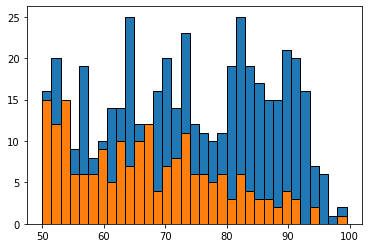

In [188]:
# confidences = 1-np.min(ICP.predict_proba(X_test_CP),axis=1)
# output_t = np.argmax(ICP.predict_proba(X_test_CP),axis=1)

confidences = np.max(CB_AF.predict_proba(X_test_CP),axis=1)
output_t = np.argmax(CB_AF.predict_proba(X_test_CP),axis=1)

bins_size = 1.5
bin_min = np.round(np.min(confidences*100))

pred_out = output_t
real_out = y_test_CP.values
bins_correct = plt.hist(confidences[np.where(pred_out==real_out)]*100,density=False,label="Correct pred",bins=np.arange(bin_min,101,bins_size),ec='black')#,color="#e898ac",ec='white')
bins_incorrect = plt.hist(confidences[np.where(pred_out!=real_out)]*100,density=False,label="Incorrect pred",bins=np.arange(bin_min,101,bins_size),ec='black')#,color="#e898ac",ec='white')

bin_means = np.array([])
bins_size_mean = bins_size/100.0
for b in np.arange(bin_min/100.0,101/100.0,bins_size_mean):
    bin_means = np.append(bin_means,np.array(np.mean(confidences[np.where((confidences > b)&(confidences <= (b+bins_size_mean)))])))

bin_means = bin_means[:-1]

#avg accuracy per bin - avg confidence per bin (summed over all bins and normalized by width of size of bin)
ECE = np.sum((bins_correct[0]+bins_incorrect[0])/len(confidences) * (np.abs(bins_correct[0]/(bins_correct[0]+bins_incorrect[0]) - bin_means)))
print("ECE = "+str(np.round(ECE,4)))

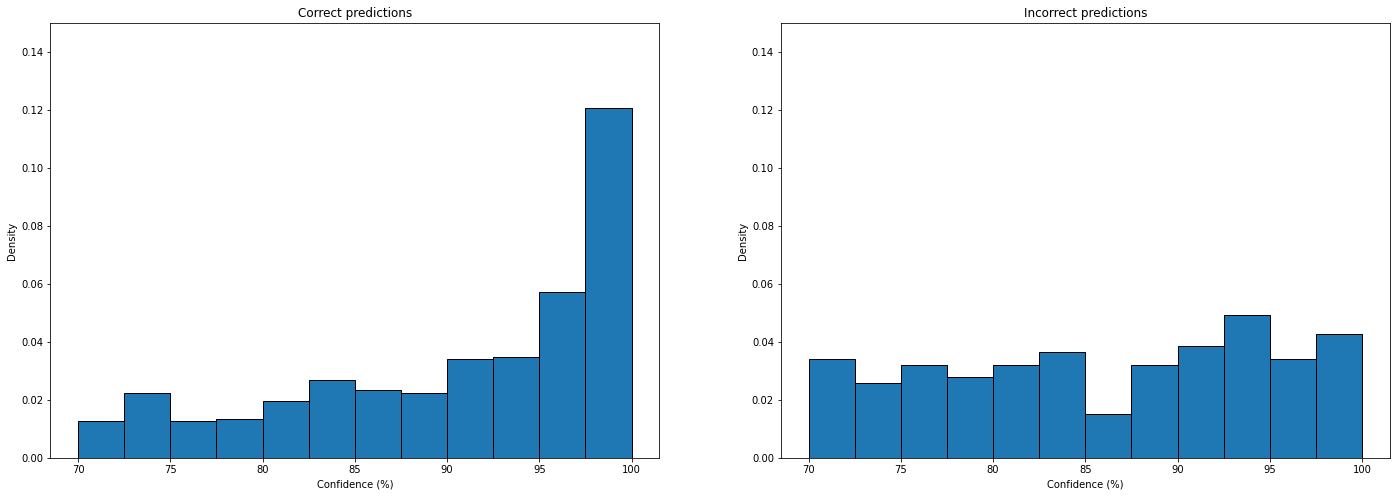

In [79]:
#credibility = largest underbound of p-values where p-value will result in no selection (in this case, just the largest of the two)
#confidence = smallest upperbound of p-values where p-value will result in the selection of only one feature (in this case, the smallest of the two)
confidences = 1-np.min(ICP.predict_proba(X_test_CP),axis=1)

output_t = np.argmax(ICP.predict_proba(X_test_CP),axis=1)
pred_out = output_t
real_out = y_test_CP.values
fig,axs = plt.subplots(1,2,figsize=(24,8))
axs[0].hist(confidences[np.where(pred_out==real_out)]*100,density=True,label="Correct pred",bins=np.arange(70,101,2.5),ec='black')#,color="#e898ac",ec='white')
axs[1].hist(confidences[np.where(pred_out!=real_out)]*100,density=True,label="Incorrect pred",bins=np.arange(70,101,2.5),ec='black')#,color="#e898ac",ec='white')
axs[0].set_xlabel("Confidence (%)")
axs[1].set_xlabel("Confidence (%)")
axs[0].set_ylabel("Density")
axs[1].set_ylabel("Density")
axs[0].set_title("Correct predictions")
axs[1].set_title("Incorrect predictions")
axs[0].set_ylim([0,0.15])
axs[1].set_ylim([0,0.15])
if present:
    axs[0].patch.set_alpha(0)
    axs[1].patch.set_alpha(0)